# Lightning Burst Analysis with Intensification Categories
 
 This notebook analyzes lightning data in relation to tropical cyclone intensification categories. It includes statistical tests and visualizations to understand distribution patterns across different detection methods.

In [2]:
#Import Required Libraries
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [ ]:
#Import Data
lightning_data = pd.read_csv('tc_lightning_vis_data.csv')
threshold_data = pd.read_csv('tc_threshold.csv')
threshold_sum = pd.read_csv('threshold_summary.csv')

#### Statistical Analysis for all lightning data
Following session analyzes the relationship between lightning burst and intensification stage with all lightning data 

In [29]:
# Group all lightning data by intensification category
burst_counts = threshold_data.groupby('Intensification_Category_3')[['burst_iqr1','burst_iqr2','burst_logn1']].sum()

burst_counts = burst_counts.reset_index()
print(burst_counts)

  Intensification_Category_3  burst_iqr1  burst_iqr2  burst_logn1
0               Intensifying         350         103          415
1                    Neutral         171          47          256
2               Unidentified         149          50          159
3                  Weakening         175          50          222


In [38]:
# See if bursts statistically significant differences for each intensification
import scipy.stats as stats

methods = ['burst_iqr1', 'burst_iqr2', 'burst_logn1']

results = {}
for method in methods:
    observed = burst_counts[method].tolist()  # Get counts for the method across all stages
    chi2, p = stats.chisquare(observed)
    results[method] = {'Chi²': chi2, 'p-value': p}

for method in results:
    print(f"{method}: χ² = {results[method]['Chi²']:.2f}, p = {results[method]['p-value']:.4f}")


burst_iqr1: χ² = 123.36, p = 0.0000
burst_iqr2: χ² = 35.09, p = 0.0000
burst_logn1: χ² = 135.55, p = 0.0000


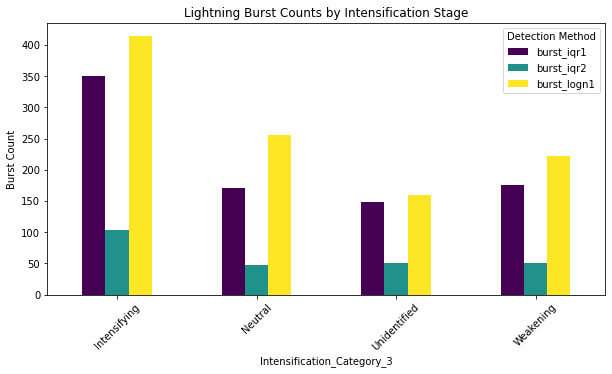

In [13]:
burst_counts.set_index("Intensification_Category_3").plot(kind="bar", figsize=(10, 5), colormap="viridis")
plt.ylabel("Burst Count")
plt.title("Lightning Burst Counts by Intensification Stage")
plt.legend(title="Detection Method")
plt.xticks(rotation=45)
plt.show()


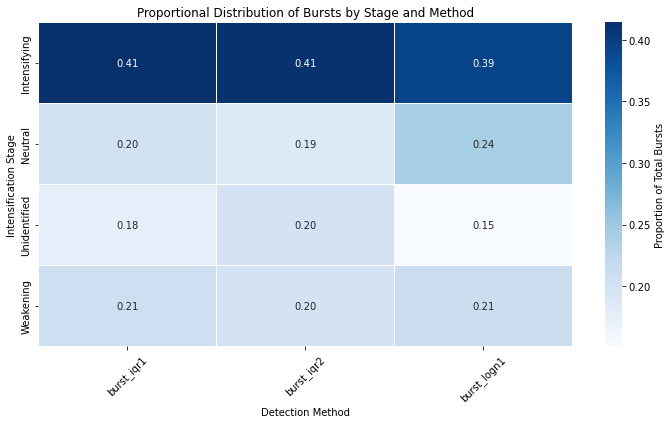

In [34]:
# Normalize data to show proportions within each method
df_normalized = burst_counts.set_index('Intensification_Category_3').apply(lambda x: x/x.sum(), axis=0)

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(df_normalized, 
            annot=True, 
            fmt=".2f", 
            cmap='Blues', 
            linewidths=0.5,
            cbar_kws={'label': 'Proportion of Total Bursts'})
plt.title('Proportional Distribution of Bursts by Stage and Method')
plt.xlabel('Detection Method')
plt.ylabel('Intensification Stage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Key Findings

- All detection methods show significant overall differences (p < 0.05), suggesting distinct lightning burst patterns across tropical cyclone life cycles
- Proportional distribution heatmap reveals more lightning burst detected at intensifying stage compare to other stages


#### Statistical Analysis for each basin
Following session will investigate basin-level patterns in lightning burst distribution across tropical cyclone intensification stages

In [ ]:
# Define the burst detection methods to analyze
methods = ['burst_iqr1', 'burst_iqr2', 'burst_logn1']

# Group data by Basin and Intensification Stage, summing up burst counts
basin_df = threshold_data.groupby(["basin", "Intensification_Category_3"])[methods].sum().reset_index()

# Initialize a list to collect all test results
all_results = []

# Perform Chi-Square test for each Basin
for basin in basin_df["basin"].unique():
    # Filter data for the current basin and set category as index
    basin_data = basin_df[basin_df["basin"] == basin].set_index("Intensification_Category_3")
    
    # Check if there are observations to test
    if basin_data.empty:
        print(f"No data available for {basin} Basin.")
        continue
    
    # Run Chi-Square test for each method
    for method in methods:
        observed = basin_data[method].tolist()
        
        # Ensure there are observed values to avoid division by zero in chi-square
        if sum(observed) == 0:
            print(f"Skipping {method} for {basin} due to zero observations.")
            continue
        
        # Perform Chi-Square test
        chi2, p = stats.chisquare(observed)
        
        # Append results to the list
        all_results.append({
            "Basin": basin,
            "Method": method,
            "p-value": p
        })

results_df = pd.DataFrame(all_results)
results_df['Significant'] = results_df['p-value'] <= 0.05 
print(results_df)

Skipping burst_iqr2 for CPAC due to zero observations.
   Basin       Method       p-value  Significant
0    ATL   burst_iqr1  4.653807e-08         True
1    ATL   burst_iqr2  3.314733e-01        False
2    ATL  burst_logn1  4.705278e-11         True
3   CPAC   burst_iqr1  2.737148e-01        False
4   CPAC  burst_logn1  1.366585e-01        False
5   EPAC   burst_iqr1  2.305469e-01        False
6   EPAC   burst_iqr2  3.207164e-02         True
7   EPAC  burst_logn1  3.382379e-03         True
8     IO   burst_iqr1  9.991685e-03         True
9     IO   burst_iqr2  2.262166e-03         True
10    IO  burst_logn1  2.505351e-03         True
11  SHEM   burst_iqr1  2.015049e-04         True
12  SHEM   burst_iqr2  8.234218e-03         True
13  SHEM  burst_logn1  1.470951e-04         True
14  WPAC   burst_iqr1  6.504405e-25         True
15  WPAC   burst_iqr2  1.851081e-05         True
16  WPAC  burst_logn1  5.474354e-26         True


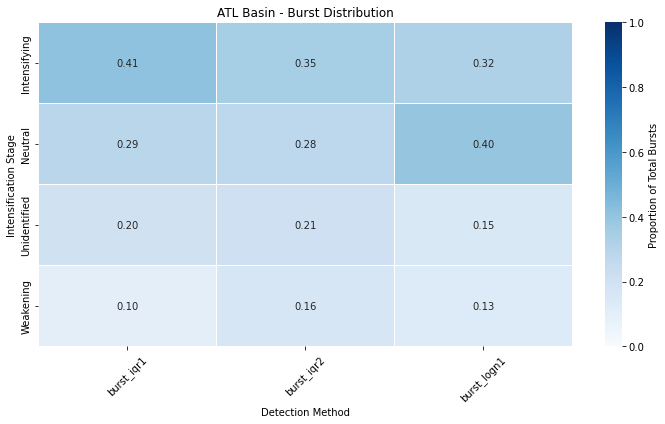

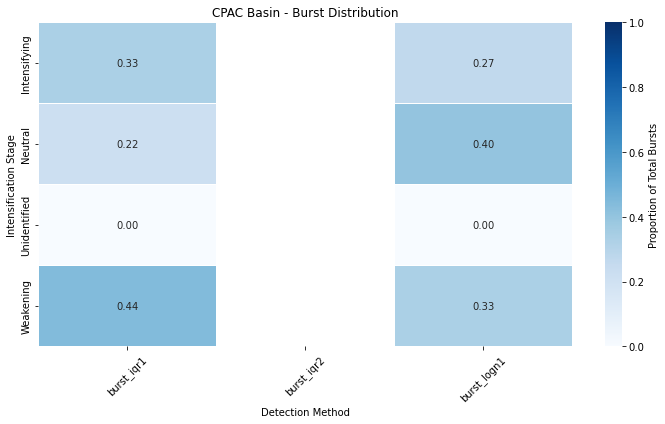

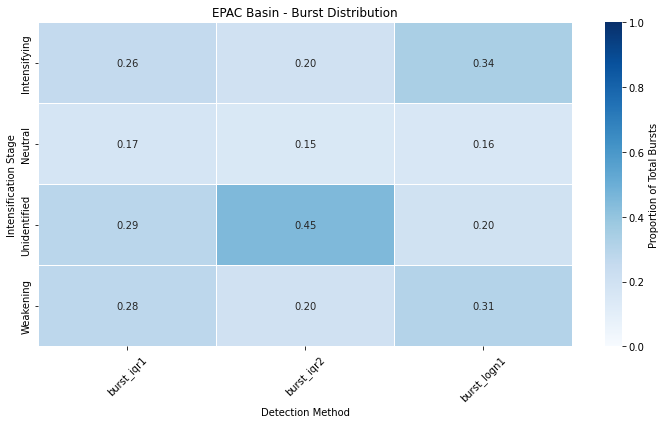

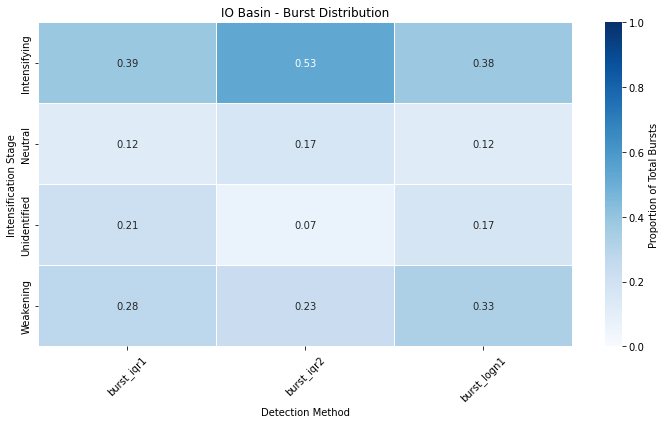

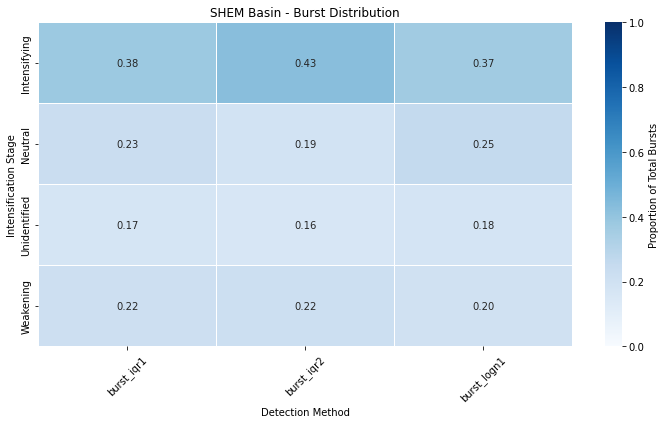

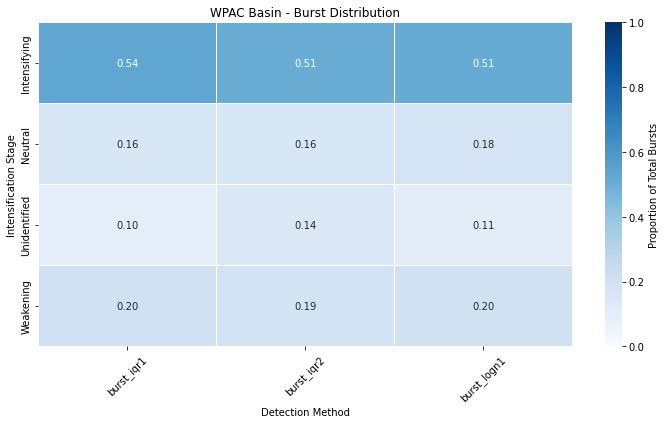

In [67]:
def create_basin_heatmap(basin):
    # Filter data for specific category
    basin_data = basin_df[basin_df['basin'] == basin]
    
    # Melt the data to long format
    melted = basin_data.melt(
        id_vars=['Intensification_Category_3'],
        value_vars=methods,
        var_name='Method',
        value_name='Burst_Count'
    )
    
    # Pivot and normalize data
    pivot_table = melted.pivot_table(
        index='Intensification_Category_3',
        columns='Method',
        values='Burst_Count',
        aggfunc='sum'
    )
    
    # Normalize within each method
    df_normalized = pivot_table.apply(lambda x: x/x.sum(), axis=0)
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_normalized,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        linewidths=0.5,
        cbar_kws={'label': 'Proportion of Total Bursts'},
        vmin=0,
        vmax=1
    )
    plt.title(f'{basin} Basin - Burst Distribution')
    plt.xlabel('Detection Method')
    plt.ylabel('Intensification Stage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generate both heatmaps
create_basin_heatmap("ATL")
create_basin_heatmap("CPAC")
create_basin_heatmap("EPAC")
create_basin_heatmap("IO")
create_basin_heatmap("SHEM")
create_basin_heatmap("WPAC")


Key Findings

- Most detection methods show significant overall differences (p < 0.05) on basin level expect CPAC
- Proportional distribution heatmap reveals most basin shows more lightning burst detected at intensifying stage except CPAC and EPAC


#### Statistical Analysis for Each Cyclone Category
Following session analyzes the lightning burst partern in each cyclone category(0-5)

In [57]:
# Define the burst detection methods to analyze
methods = ['burst_iqr1', 'burst_iqr2', 'burst_logn1']

# Group data by Category and Intensification Stage, summing up burst counts
cat_df = threshold_data.groupby(["Current_Category", "Intensification_Category_3"])[methods].sum().reset_index()

# Initialize a list to collect all test results
all_results = []

# Perform Chi-Square test for each Category
for cat in cat_df["Current_Category"].unique():
    # Filter data for the current basin and set category as index
    cat_data = cat_df[cat_df["Current_Category"] == cat].set_index("Intensification_Category_3")
    
    # Check if there are observations to test
    if cat_data.empty:
        print(f"No data available for {cat}.")
        continue
    
    # Run Chi-Square test for each method
    for method in methods:
        observed = cat_data[method].tolist()
        
        # Ensure there are observed values to avoid division by zero in chi-square
        if sum(observed) == 0:
            print(f"Skipping {method} for {cat} due to zero observations.")
            continue
        
        # Perform Chi-Square test
        chi2, p = stats.chisquare(observed)
        
        # Append results to the list
        all_results.append({
            "Category": cat,
            "Method": method,
            "p-value": p
        })

results_df2 = pd.DataFrame(all_results)
results_df2['Significant'] = results_df2['p-value'] <= 0.05 
print(results_df2)

    Category       Method       p-value  Significant
0          0   burst_iqr1  2.960853e-45         True
1          0   burst_iqr2  9.884759e-17         True
2          0  burst_logn1  3.106244e-47         True
3          1   burst_iqr1  4.922750e-02         True
4          1   burst_iqr2  9.342791e-01        False
5          1  burst_logn1  2.175170e-01        False
6          2   burst_iqr1  2.276471e-01        False
7          2   burst_iqr2  5.755845e-02        False
8          2  burst_logn1  3.078307e-03         True
9          3   burst_iqr1  2.628962e-03         True
10         3   burst_iqr2  3.671132e-03         True
11         3  burst_logn1  3.903977e-03         True
12         4   burst_iqr1  3.770671e-05         True
13         4   burst_iqr2  3.916252e-01        False
14         4  burst_logn1  1.302654e-08         True
15         5   burst_iqr1  2.647768e-02         True
16         5   burst_iqr2  3.916252e-01        False
17         5  burst_logn1  1.283912e-03       

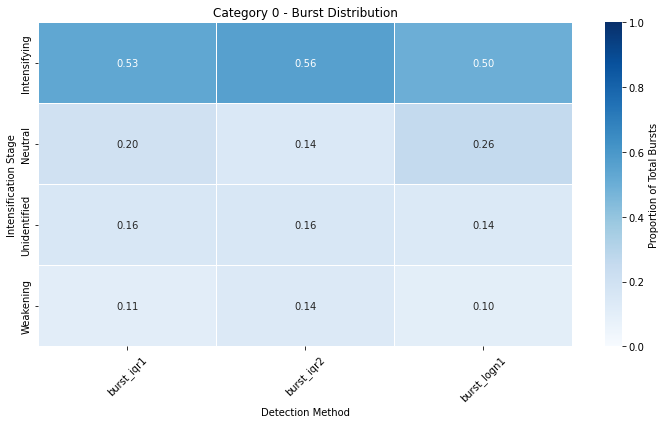

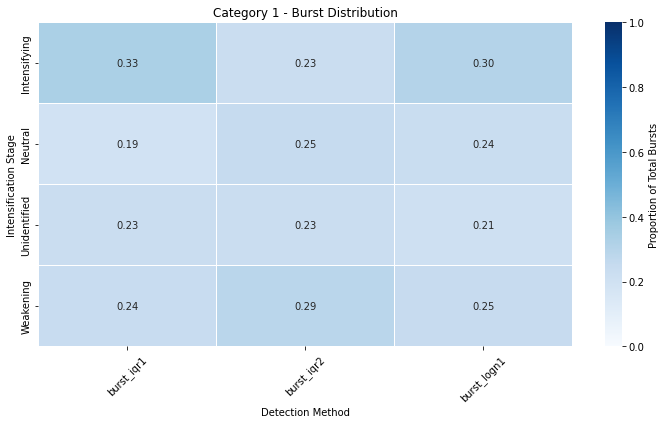

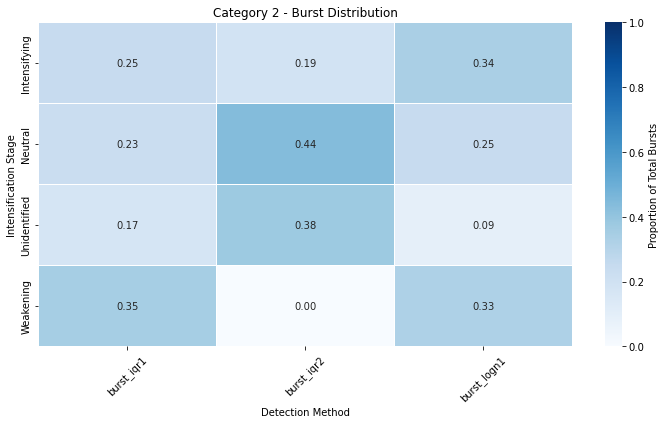

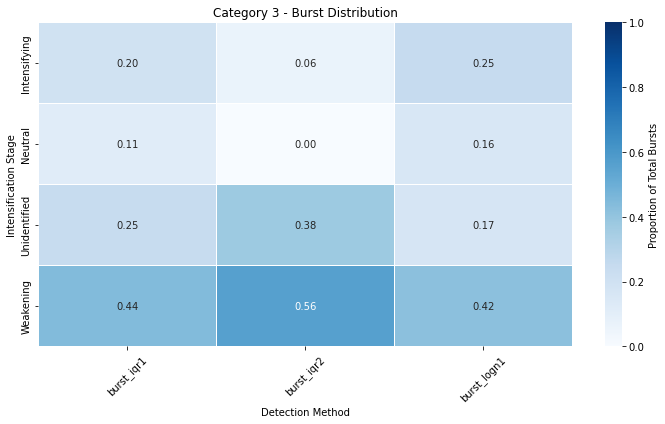

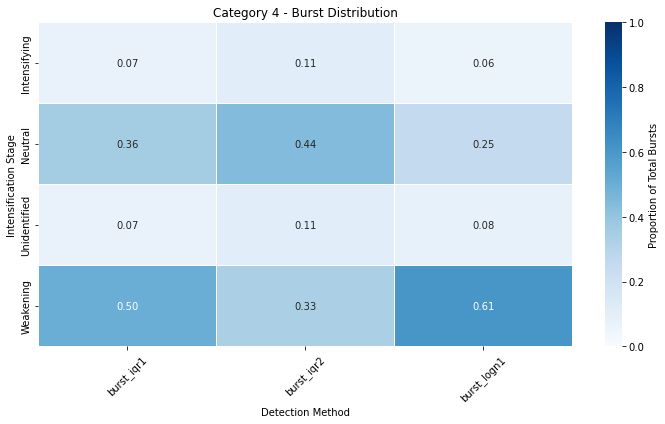

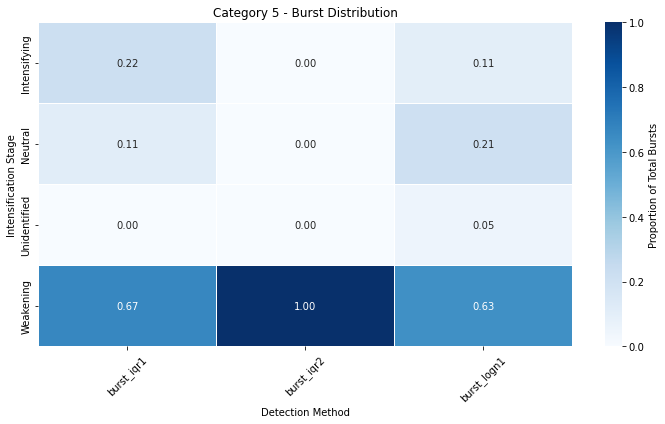

In [65]:
def create_category_heatmap(category_number):
    # Filter data for specific category
    cat_data = cat_df[cat_df['Current_Category'] == category_number]
    
    # Melt the data to long format
    melted = cat_data.melt(
        id_vars=['Intensification_Category_3'],
        value_vars=methods,
        var_name='Method',
        value_name='Burst_Count'
    )
    
    # Pivot and normalize data
    pivot_table = melted.pivot_table(
        index='Intensification_Category_3',
        columns='Method',
        values='Burst_Count',
        aggfunc='sum'
    )
    
    # Normalize within each method
    df_normalized = pivot_table.apply(lambda x: x/x.sum(), axis=0)
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_normalized,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        linewidths=0.5,
        cbar_kws={'label': 'Proportion of Total Bursts'},
        vmin=0,
        vmax=1
    )
    plt.title(f'Category {category_number} - Burst Distribution')
    plt.xlabel('Detection Method')
    plt.ylabel('Intensification Stage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generate both heatmaps
create_category_heatmap(0)
create_category_heatmap(1)
create_category_heatmap(2)
create_category_heatmap(3)
create_category_heatmap(4)
create_category_heatmap(5)


Key Findings:

- Method Performance

    - burst_logn1: Reliable in 5/6 categories (Categories 0,2,3,4,5), strongest in Category 0 (p=3e-47).

    - burst_iqr1: Effective for Categories 0,3,4,5, weakest in Category 1 (p=0.049).

    - burst_iqr2: Only valid for Categories 0 and 3, unreliable elsewhere.
- Category Trends

    - Category 0: All methods show extreme significance (p < 1e-16).

    - Category 1: No method fully reliable (highest p=0.049).

    - Categories 3-5: Consistent results with burst_logn1 (p ≤ 0.004).
- Heat map

    - Category 0: more lightning burst occurs in intensifying stage
    - Category 1&2: no signicant difference
    - Category 3-5: more lightning burst occurs in weakening stage

#### Statistical Analysis for Grouped Cyclone Category
Due to the lightning burst distribution difference in each category, following session will compare lightning bursts by intensity tier

-  Intensity Category Groupng:
    - Group 0-2: Developing/Moderate-intensity cyclones  
    - Group 3-5: Major hurricanes 

In [73]:
# 1. Create Combined Categories
cat_bins = [-1, 2.5, 5]  # -1 to catch 0 values
cat_labels = ['Group 0-2', 'Group 3-5']
threshold_data['Category_Group'] = pd.cut(threshold_data['Current_Category'], 
                                       bins=cat_bins, 
                                       labels=cat_labels)

# 2. Group Data by New Categories
methods = ['burst_iqr1', 'burst_iqr2', 'burst_logn1']
grouped_df = threshold_data.groupby(["Category_Group", "Intensification_Category_3"])[methods].sum().reset_index()
cat_group_results = []

for cat in grouped_df["Category_Group"].unique():
    # Filter data for the current basin and set category as index
    cat_data = grouped_df[grouped_df["Category_Group"] == cat].set_index("Intensification_Category_3")
    
    # Run Chi-Square test for each method
    for method in methods:
        observed = cat_data[method].tolist()
        
        # Ensure there are observed values to avoid division by zero in chi-square
        if sum(observed) == 0:
            print(f"Skipping {method} for {cat} due to zero observations.")
            continue
        
        # Perform Chi-Square test
        chi2, p = stats.chisquare(observed)
        
        # Append results to the list
        cat_group_results.append({
            "Category": cat,
            "Method": method,
            "p-value": p
        })

results_df3 = pd.DataFrame(cat_group_results)
results_df3['Significant'] = results_df3['p-value'] <= 0.05 
print(results_df3)


    Category       Method       p-value  Significant
0  Group 0-2   burst_iqr1  1.383576e-35         True
1  Group 0-2   burst_iqr2  1.554015e-10         True
2  Group 0-2  burst_logn1  1.049028e-38         True
3  Group 3-5   burst_iqr1  3.334363e-07         True
4  Group 3-5   burst_iqr2  1.399826e-02         True
5  Group 3-5  burst_logn1  4.616056e-12         True


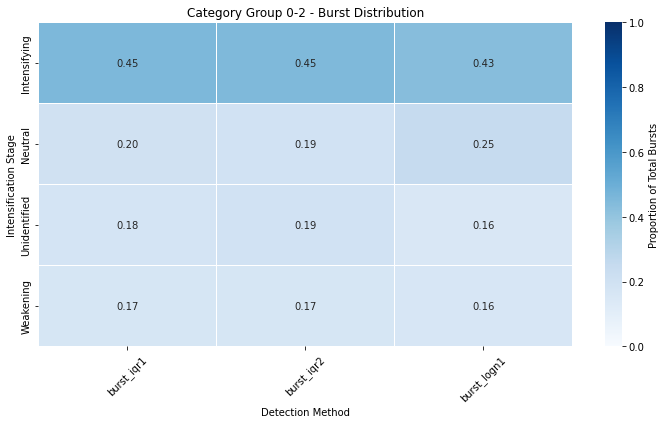

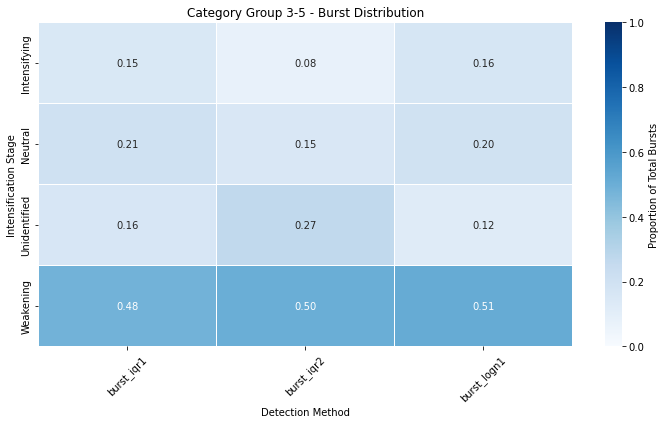

In [74]:
# Heatmap Visualization for grouped category
def group_category_heatmap(grouped_category):
    # Filter data for specific category
    cat_data = grouped_df[grouped_df['Category_Group'] == grouped_category]
    
    # Melt the data to long format
    melted = cat_data.melt(
        id_vars=['Intensification_Category_3'],
        value_vars=methods,
        var_name='Method',
        value_name='Burst_Count'
    )
    
    # Pivot and normalize data
    pivot_table = melted.pivot_table(
        index='Intensification_Category_3',
        columns='Method',
        values='Burst_Count',
        aggfunc='sum'
    )
    
    # Normalize within each method
    df_normalized = pivot_table.apply(lambda x: x/x.sum(), axis=0)
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_normalized,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        linewidths=0.5,
        cbar_kws={'label': 'Proportion of Total Bursts'},
        vmin=0,
        vmax=1
    )
    plt.title(f'Category {grouped_category} - Burst Distribution')
    plt.xlabel('Detection Method')
    plt.ylabel('Intensification Stage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generate both heatmaps
group_category_heatmap("Group 0-2")
group_category_heatmap("Group 3-5")


Key Findings:

- All detection methods show statistically significant differences (p < 0.05) in lightning burst patterns for both intensity groups
- burst_logn1 method demonstrates exceptional sensitivity
- For Category 0-2 cyclones, more bursts occur during the intensifying stage, consistent with findings from all lightning data
- For Category 3-5 cyclones, most bursts are detected during the weakening stage